In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Numba benchmark for univariate Runge-Kutta SDE solver

In [270]:
@jit(nopython=True, parallel=False, fastmath=True)
def runge_kutta_solver(a, b, x0=1, n_steps=200, time_horizon=1, n_samples=1):
    t = np.linspace(0, time_horizon, n_steps)
    delta = t[1]-t[0]
    x_markov = np.zeros((n_steps, n_samples))
    x_markov[0, :]  = x0#*np.ones(n_samples)
    for i in range(n_steps-1):
        dW = np.random.randn(n_samples)*np.sqrt(delta) # NB: we don't actually have to vectorize in sample space when using numba
        x = x_markov[i,:]
        ti = t[i]
        b_diff = b(x+a(x, ti)*delta+b(x, ti)*np.sqrt(delta), ti)-b(x, ti)
        x_markov[i+1, :] = x + a(x, ti)*delta+b(x, ti)*dW+b_diff*(dW**2-delta)/(2*np.sqrt(delta))
    return t, x_markov

In [190]:
# Geometric BM:

@jit('float64[::1](float64[::1], float64)', nopython=True)
def a(x, t):
    return 1*x

@jit('float64[::1](float64[::1], float64)', nopython=True)
def b(x, t):
    return 0.2*x

In [160]:
%%time
# Base
_, out = runge_kutta_solver(lambda x: x, lambda x: 0.2*x, time_horizon=2, n_samples=10,  n_steps=1000)

Wall time: 19 ms


In [195]:
%%time
# nopython
_, out = runge_kutta_solver(a, b, time_horizon=2, n_samples=10, n_steps=1000)

Wall time: 500 µs


In [174]:
%%time
# nopython+parallel
_, out = runge_kutta_solver(a, b, time_horizon=2, n_samples=10)

Wall time: 17.5 ms


## Ornstein–Uhlenbeck process

$$
dX_t = \kappa(\mu-X_t)dt+\sigma dW_t
$$

In [271]:
@jit('float64[::1](float64[::1], float64)', nopython=True, fastmath=True)
def a(x, t):
    return (1/2-x)

@jit('float64[::1](float64[::1], float64)', nopython=True, fastmath=True)
def b(x, t):
    return 0.1*np.ones(len(x))

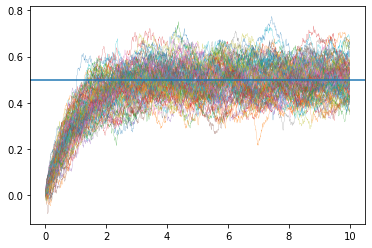

In [272]:
t, x = runge_kutta_solver(a, b, n_steps=1000, n_samples=100, x0=0, time_horizon=10)
plt.plot(t, x, lw=0.2);
plt.axhline(1/2);

## Brownian bridge
$$
dX_t = \frac{b-X_t}{1-t}dt+dW_t, \quad t\in[0,1), X_0=a
$$
This gives $X_{t=1}=b$

In [255]:
@jit('float64[::1](float64[::1], float64)', nopython=True, fastmath=True)
def a(x, t):
    return (1-x)/(1.01-t)

@jit('float64[::1](float64[::1], float64)', nopython=True, fastmath=True)
def b(x, t):
    return np.ones(len(x))

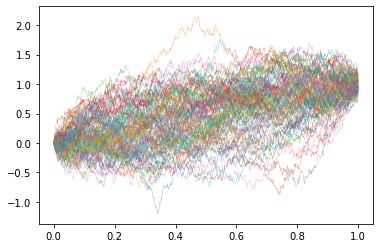

In [258]:
t, x = runge_kutta_solver(a, b, n_steps=1000, n_samples=100, x0=0, time_horizon=1)
plt.plot(t, x, lw=0.2);

## Geometric mean reversion
$$
dX_t = \kappa(\alpha-\log X_t)X_tdt+\sigma X_tdW_t
$$

In [259]:
@jit('float64[::1](float64[::1], float64)', nopython=True, fastmath=True)
def a(x, t):
    return 0.2*(1-np.log(x))*x

@jit('float64[::1](float64[::1], float64)', nopython=True, fastmath=True)
def b(x, t):
    return 0.3*x

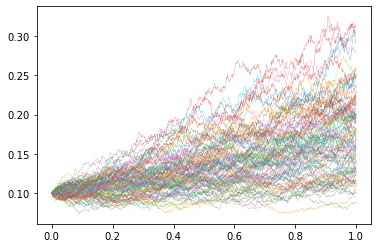

In [268]:
t, x = runge_kutta_solver(a, b, n_steps=1000, n_samples=100, x0=0.1, time_horizon=1)
plt.plot(t, x, lw=0.2);

# Coupled SDEs

Consider the Kalman filtering problem (in 1d):
$$
\begin{aligned}
dX_t&=F(t)X_tdt+C(t)dU_t\\
dZ_t&=G(t)X_tdt+D(t)dV_t
\end{aligned}
$$